In [1]:
import os
import sys
sys.path.append("../../")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.f1 = nn.Linear(6, 128)
        self.f2 = nn.Linear(128, 128)
        self.f3 = nn.Linear(128, 128)
        self.f4 = nn.Linear(128, 1)
        
    def forward(self, pos,theta):
        x = torch.cat([pos,theta], dim=1)
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = F.relu(self.f3(x))
        x = F.sigmoid(self.f4(x))
        return x

# Instantiate the model
obs_model = NN()

# Load the model
obs_model.load_state_dict(torch.load('obs_model_4.pth',map_location=torch.device('cpu') ,weights_only=True))

obs_model.eval()
obs_model(torch.tensor([0.5, 0.5]).unsqueeze(0), torch.tensor([0.5, 0.0, 0.0, 0.5]).unsqueeze(0))

tensor([[0.2173]], grad_fn=<SigmoidBackward0>)

In [3]:
from environment.env import POMDPDeformedGridworld
pomdp_env = POMDPDeformedGridworld()
pomdp_env.reset()

({'obs': tensor(0.), 'pos': tensor([0.2120, 0.6438])}, {})

# trajectory generation

In [4]:
pomdp_env.reset()
print(pomdp_env.transformation_matrix)
s = pomdp_env.get_state()
pos = [s['pos']]
obs = [s['obs']]
previous_pos = pos[0]
while True:
    try:
        state, _, _, _, _ = pomdp_env.render()
        if state is not None:
            if not torch.all(torch.eq(state['pos'], previous_pos)):
                pos.append(state['pos'])
                obs.append(state['obs'])
                previous_pos = state['pos']
                predicted_obs = torch.distributions.Bernoulli(obs_model(state['pos'].unsqueeze(0),torch.tensor(pomdp_env.transformation_matrix).flatten().unsqueeze(0))).sample().squeeze()
                print(f"POS : {state['pos']}, OBS : {state['obs']}, PRED-OBS : {predicted_obs}")
    except:
        print('Error')
        break
    

[[0.4714524384049505, -0.010210152613124052], [0.07155517789355248, 0.6833521308571476]]
POS : tensor([0.0496, 0.1356]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.0496, 0.1556]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.0496, 0.1756]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.0696, 0.1756]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.0696, 0.1956]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.0896, 0.1956]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.0896, 0.2156]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.0896, 0.2356]), OBS : 0.0, PRED-OBS : 0.0
POS : tensor([0.0896, 0.2556]), OBS : 1.0, PRED-OBS : 1.0
POS : tensor([0.0896, 0.2756]), OBS : 1.0, PRED-OBS : 1.0
POS : tensor([0.1096, 0.2756]), OBS : 1.0, PRED-OBS : 1.0
POS : tensor([0.1096, 0.2956]), OBS : 1.0, PRED-OBS : 1.0
POS : tensor([0.1296, 0.2956]), OBS : 1.0, PRED-OBS : 1.0
POS : tensor([0.1296, 0.3156]), OBS : 1.0, PRED-OBS : 1.0
POS : tensor([0.1296, 0.3356]), OBS : 1.0, PRED-OBS : 1.0
POS : tensor([0.1296, 0.3556]), OBS : 1.0

In [5]:
positions, observations = pos, obs
len(observations)

57

# VI L_a estimator

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal



def likelihood(X,y,theta):
    """
    y: observation
    X: position of the agent
    theta: deformation parameter (sampled from the variational distribution)
    
    Returns the log likelihood of the observation y given the position X and the deformation parameter theta
    """
    # print(X.shape, theta.shape)
    f_theta = obs_model(X, theta)
    return torch.distributions.Bernoulli(f_theta).log_prob(y).sum()

# Define the prior
def prior(theta):
    mu = torch.tensor([torch.mean(torch.tensor(pomdp_env.stretch_range)),
                    torch.mean(torch.tensor(pomdp_env.shear_range)),
                    torch.mean(torch.tensor(pomdp_env.shear_range)),
                    torch.mean(torch.tensor(pomdp_env.stretch_range))])
    sigma = torch.tensor([.5,.5,.5,.5])
    return Normal(mu, sigma).log_prob(theta).sum()

# Variational distribution (q_lambda)
class VariationalDistribution(nn.Module):
    def __init__(self, dim):
        super(VariationalDistribution, self).__init__()
        self.mu = nn.Parameter(torch.zeros(dim))
        self.log_sigma = nn.Parameter(torch.zeros(dim))
    
    def sample(self, num_samples=1):
        epsilon = torch.randn(num_samples, self.mu.size(0), device=self.mu.device)
        sigma = torch.exp(self.log_sigma)
        return self.mu + sigma * epsilon  # Reparameterization trick
    
    def log_prob(self, theta):
        sigma = torch.exp(self.log_sigma)
        return Normal(self.mu, sigma).log_prob(theta).sum()
    
    def entropy(self):
        sigma = torch.exp(self.log_sigma)
        return Normal(self.mu, sigma).entropy().sum()

# BBVI Training Loop
def bbvi(X, y, variational_dist, num_epochs=5000, num_samples=10, lr=0.01):
    optimizer = optim.Adam(variational_dist.parameters(), lr=lr)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Monte Carlo approximation of ELBO
        elbo = 0
        for i in range(num_samples):
            # Sample theta ~ q_lambda
            theta = variational_dist.sample()#(X.shape[0]) 
            theta = theta.repeat(X.shape[0],1)
            # Log likelihood p(x|theta) where theta is sampled from the variational distribution
            log_likelihood = likelihood(X,y,theta)
            
            # Log prior
            log_prior = prior(theta)
            
            # Log variational density
            log_q = variational_dist.log_prob(theta)
            
            # ELBO term
            elbo += log_likelihood + log_prior - log_q
        
        elbo /= num_samples  # Average over samples
        
        # Maximize ELBO (minimize negative ELBO)
        loss = -elbo
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, ELBO: {elbo.item():.4f}")
            print(f"Variational entropy: {variational_dist.entropy().item():.4f}")
    return variational_dist



In [58]:
# X va sostituito con gli stati del pomdp (x,y)
X = torch.stack(positions)

# y va sostituito con le osservazioni del pomdp negli stati pos=(x.y)
y = torch.stack(observations)

# true_theta va sostituito con i parametri reali del pomdp
true_theta = pomdp_env.transformation_matrix 

# print(X.shape, true_theta.shape, y.shape)

# Initialize variational distribution
variational_dist = VariationalDistribution(dim=4)

# Train with BBVI
trained_dist = bbvi(X, y, variational_dist, num_epochs=50, num_samples=500, lr=0.05)

# Output trained variational parameters
print(f"Variational Mean: {trained_dist.mu.detach().numpy()}")
print(f"Variational Log Std: {trained_dist.log_sigma.detach().numpy()}")

print(f"True Theta: {true_theta}")

Epoch 10, ELBO: -25962.5293
Variational entropy: 4.8743
Epoch 20, ELBO: -23939.4980
Variational entropy: 3.4748
Epoch 30, ELBO: -20333.4336
Variational entropy: 1.5732
Epoch 40, ELBO: -16172.3447
Variational entropy: -0.3459
Epoch 50, ELBO: -11909.1602
Variational entropy: -2.5454
Variational Mean: [ 1.0493237   0.05823155 -1.1842995   2.0302737 ]
Variational Log Std: [-1.9209076 -2.152432  -2.238774  -1.9090524]
True Theta: [[0.6856707071570237, 0.07479219888600463], [-0.05770537881008486, 0.8706924686393791]]


# L_B estimator

In [11]:
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.optim import Adam
import numpy as np

class VariationalBayesianInference:
   
    def __init__(self, f, input_dim, latent_dim=1, hidden_dim=32):
        """
        Initialize the variational Bayesian inference model.
        
        Args:
            f: callable, the known function linking X and y through theta
            input_dim: int, dimension of input X
            latent_dim: int, dimension of latent parameter theta
            hidden_dim: int, dimension of hidden layers in the neural network
        """
        self.f = f
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Variational parameters (mean and log variance of q(theta))
        self.q_mu = nn.Parameter(torch.randn(latent_dim))
        self.q_logvar = nn.Parameter(torch.zeros(latent_dim))
        
        # Prior parameters (assumed to be standard normal)
        # self.prior = dist.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
        prior_mu = torch.tensor([torch.mean(torch.tensor(pomdp_env.stretch_range)),
                    torch.mean(torch.tensor(pomdp_env.shear_range)),
                    torch.mean(torch.tensor(pomdp_env.shear_range)),
                    torch.mean(torch.tensor(pomdp_env.stretch_range))])
        prior_sigma = torch.tensor([1,1,1,1])
        self.prior = dist.Normal(prior_mu, prior_sigma)
     
    def sample_latent(self, n_samples=1):
        """Sample from the variational distribution q(theta) 
           using the reparameterization trick
        """
        eps = torch.randn(n_samples, self.latent_dim)
        std = torch.exp(0.5 * self.q_logvar)
        return self.q_mu + eps * std
    
    def elbo(self, X, y, n_samples=10):
        """
        Compute the evidence lower bound (ELBO)
        
        Args:
            X: torch.Tensor, input data (batch_size, input_dim)
            y: torch.Tensor, observations (batch_size,)
            n_samples: int, number of Monte Carlo samples
        """
        batch_size = X.shape[0]
        
        # Sample from variational distribution
        theta_samples = self.sample_latent(n_samples)  # (n_samples, latent_dim)
        
        # Compute log likelihood for each sample
        log_likelihood = torch.zeros(n_samples, batch_size)
        for i in range(n_samples):
            theta = theta_samples[i]
            y_pred = self.f(X, theta.expand(batch_size, -1)).squeeze()
            # Assuming Bernoulli observation model
            log_likelihood[i] = dist.Bernoulli(y_pred).log_prob(y)
        
        # Average over samples
        expected_log_likelihood = torch.mean(log_likelihood, dim=0).sum()
        
        # Compute KL divergence
        q_dist = dist.Normal(self.q_mu, torch.exp(0.5 * self.q_logvar))
        kl_div = dist.kl_divergence(q_dist, self.prior).sum()
        
        return expected_log_likelihood - kl_div
    
    def elbo_bis(self, X, y, n_samples=10):
        """
        Compute the evidence lower bound (ELBO)
        
        Args:
            X: torch.Tensor, input data (batch_size, input_dim)
            y: torch.Tensor, observations (batch_size,)
            n_samples: int, number of Monte Carlo samples
        """
        batch_size = X.shape[0]
        
        # Sample from variational distribution
        theta_samples = self.sample_latent(n_samples * batch_size)  # (n_samples, latent_dim)
        
        # Compute log likelihood for each sample
        log_likelihood = torch.zeros(n_samples, batch_size)
        for i in range(0,n_samples*batch_size, batch_size):
            theta = theta_samples[i:i+batch_size]
            y_pred = self.f(X, theta).squeeze()
            # Assuming Bernoulli observation model
            log_likelihood[i//batch_size] = dist.Bernoulli(y_pred).log_prob(y)
        
        # Average over samples
        expected_log_likelihood = torch.mean(log_likelihood, dim=0).sum()
        
        # Compute KL divergence
        q_dist = dist.Normal(self.q_mu, torch.exp(0.5 * self.q_logvar))
        kl_div = dist.kl_divergence(q_dist, self.prior).sum()
        
        return expected_log_likelihood - kl_div
    
    def fit(self, X, y, n_epochs=100, batch_size=64, lr=0.1):
        """
        Fit the model using variational inference
        
        Args:
            X: torch.Tensor, input data
            y: torch.Tensor, observations
            n_epochs: int, number of training epochs
            batch_size: int, batch size for stochastic optimization
            lr: float, learning rate
        """
        optimizer = Adam([self.q_mu, self.q_logvar], lr=lr)
        
        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for epoch in range(n_epochs):
            epoch_loss = 0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                loss = -self.elbo(batch_X, batch_y,1000)  # Negative because we minimize
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(dataloader):.4f}, Estimated theta mean: {self.q_mu.detach().numpy()}")
    
    def get_posterior_params(self):
        """Return the learned posterior parameters"""
        return {
            'mean': self.q_mu.detach(),
            'std': torch.exp(0.5 * self.q_logvar).detach()
        }

In [ ]:
# X = posizione dell'agente (x,y)
X = torch.stack(positions)

# ossevrazioni dell'agente negli stati pos=(x,y)
y = torch.stack(observations)

# true_theta deformazione reale dell'ambiente
true_theta = pomdp_env.transformation_matrix 

# Create and fit the model
model = VariationalBayesianInference(obs_model, input_dim=2, latent_dim=4)
model.fit(X, y, n_epochs=1000, lr=0.05)

# Get the learned posterior parameters
posterior = model.get_posterior_params()
print("Estimated theta (mean):", posterior['mean'])
print("Posterior standard deviation:", posterior['std'])

print("True theta:", true_theta)

In [16]:
# check everything is working
theta = torch.tensor([ [ 1.4882014, 1.6038883,-1.7425169, 4.7037725]])
theta = torch.tensor(pomdp_env.transformation_matrix).flatten()
y_pred = obs_model(X, theta.expand(X.shape[0], -1))
# # Assuming Bernoulli observation model
log_likelihood = dist.Bernoulli(y_pred.squeeze()).log_prob(y).sum()
log_likelihood


tensor(-0.4553, grad_fn=<SumBackward0>)

# Bounded VI

In [36]:
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.optim import Adam

class BoundedVariationalBayesianInference:
    def __init__(self, f, input_dim, latent_dim=1, bounds=None):
        """
        Initialize the variational Bayesian inference model with parameter bounds.
        
        Args:
            f: callable, the known function linking X and y through theta (must be differentiable)
            input_dim: int, dimension of input X
            latent_dim: int, dimension of latent parameter theta
            bounds: tuple or list of tuples, (lower_bound, upper_bound) for each parameter
                   If single tuple, same bounds applied to all parameters
        """
        self.f = f
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Handle bounds
        if bounds is None:
            self.bounds = None
        elif isinstance(bounds[0], (int, float)):
            # Same bounds for all parameters
            self.bounds = [(bounds[0], bounds[1])] * latent_dim
        else:
            # Different bounds for each parameter
            assert len(bounds) == latent_dim
            self.bounds = bounds
            
        # Convert bounds to tensors for efficient computation
        if self.bounds is not None:
            self.bounds_lower = torch.tensor([b[0] for b in self.bounds])
            self.bounds_upper = torch.tensor([b[1] for b in self.bounds])
        
        # Variational parameters (unconstrained)
        self.q_mu = nn.Parameter(torch.randn(latent_dim))
        self.q_logvar = nn.Parameter(torch.zeros(latent_dim))
    
    def transform_params(self, params):
        """Transform unconstrained parameters to respect bounds"""
        if self.bounds is None:
            return params
        
        # Vectorized transformation
        return self.bounds_lower + (self.bounds_upper - self.bounds_lower) * torch.sigmoid(params)
    
    def sample_latent(self, n_samples=1):
        """Sample from the variational distribution q(theta)"""
        eps = torch.randn(n_samples, self.latent_dim)
        std = torch.exp(0.5 * self.q_logvar)
        unconstrained = self.q_mu + eps * std
        return self.transform_params(unconstrained)
    
    def compute_log_prior(self, theta_samples):
        """Compute log prior probability for bounded uniform prior"""
        if self.bounds is None:
            # Standard normal prior
            return dist.Normal(0, 1).log_prob(theta_samples).sum(-1)
        else:
            # Check if samples are within bounds
            in_bounds = torch.all(
                (theta_samples >= self.bounds_lower) & 
                (theta_samples <= self.bounds_upper),
                dim=-1
            )
            
            # Log probability of uniform prior
            log_prior = torch.sum(
                torch.log(1.0 / (self.bounds_upper - self.bounds_lower)),
                dim=-1
            )
            
            return torch.where(in_bounds, log_prior, torch.tensor(float('-inf')))
    
    def elbo(self, X, y, n_samples=10):
        """
        Compute the evidence lower bound (ELBO)
        
        Args:
            X: torch.Tensor, input data (batch_size, input_dim)
            y: torch.Tensor, observations (batch_size,)
            n_samples: int, number of Monte Carlo samples
        """
        batch_size = X.shape[0]
        
        # Sample from variational distribution
        theta_samples = self.sample_latent(n_samples)  # [n_samples, latent_dim]
        
        # Compute log likelihood for each sample
        log_likelihood = torch.zeros(n_samples, batch_size)
        for i in range(n_samples):
            theta = theta_samples[i]
            y_pred = self.f(X, theta.expand(batch_size, -1)).squeeze()
            log_likelihood[i] = dist.Bernoulli(y_pred).log_prob(y)
        
        # Average over samples
        expected_log_likelihood = torch.mean(log_likelihood, dim=0).sum()
        
        # Compute KL divergence
        if self.bounds is None:
            # For unbounded case, use analytical KL
            prior = dist.Normal(torch.zeros(self.latent_dim), torch.ones(self.latent_dim))
            q_dist = dist.Normal(self.q_mu, torch.exp(0.5 * self.q_logvar))
            kl_div = dist.kl_divergence(q_dist, prior).sum()
        else:
            # For bounded case, use Monte Carlo estimate of KL
            q_dist = dist.Normal(self.q_mu, torch.exp(0.5 * self.q_logvar))
            log_q = q_dist.log_prob(theta_samples).sum(-1)  # [n_samples]
            log_p = self.compute_log_prior(theta_samples)    # [n_samples]
            kl_div = torch.mean(log_q - log_p)
        
        return expected_log_likelihood - kl_div
    
    def fit(self, X, y, n_epochs=1000, batch_size=32, lr=0.01):
        """
        Fit the model using variational inference
        
        Args:
            X: torch.Tensor, input data
            y: torch.Tensor, observations
            n_epochs: int, number of training epochs
            batch_size: int, batch size for stochastic optimization
            lr: float, learning rate
        """
        optimizer = Adam([self.q_mu, self.q_logvar], lr=lr)
        
        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_epochs):
            epoch_loss = 0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                loss = -self.elbo(batch_X, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(dataloader):.4f}, Estimated theta mean: {self.transform_params(self.q_mu.detach())}")
    
    def get_posterior_params(self):
        """Return the learned posterior parameters (transformed to respect bounds)"""
        unconstrained_mean = self.q_mu.detach()
        transformed_mean = self.transform_params(unconstrained_mean)
        # Note: std is approximate due to non-linear transformation
        return {
            'mean': transformed_mean,
            'std': torch.exp(0.5 * self.q_logvar).detach()
        }

In [37]:
# X = posizione dell'agente (x,y)
X = torch.stack(positions)

# ossevrazioni dell'agente negli stati pos=(x,y)
y = torch.stack(observations)

# true_theta deformazione reale dell'ambiente
true_theta = pomdp_env.transformation_matrix 

# Create and fit the model
model = BoundedVariationalBayesianInference(obs_model, input_dim=2, latent_dim=4, bounds=(-.2, 1))
model.fit(X, y, n_epochs=1000, lr=0.05)

# Get the learned posterior parameters
posterior = model.get_posterior_params()
print("Estimated theta (mean):", posterior['mean'])
print("Posterior standard deviation:", posterior['std'])

print("True theta:", true_theta)

Epoch 100/1000, Loss: -1360986.6250, Estimated theta mean: tensor([ 0.6321, -0.1449, -0.2000,  0.9866])
Epoch 200/1000, Loss: -852494325133053263872.0000, Estimated theta mean: tensor([ 1.0000, -0.2000, -0.2000,  1.0000])


ValueError: Expected parameter probs (Tensor of shape (32,)) of distribution Bernoulli(probs: torch.Size([32])) to satisfy the constraint Interval(lower_bound=0.0, upper_bound=1.0), but found invalid values:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], grad_fn=<SqueezeBackward0>)

# metropolis

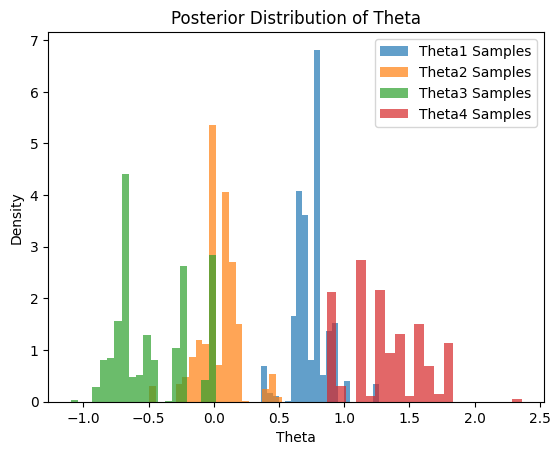

Mean of theta1: 0.7420249581336975
Mean of theta2: 0.03706667572259903
Mean of theta3: -0.46467968821525574
Mean of theta4: 1.3048193454742432
[[0.6856707071570237, 0.07479219888600463], [-0.05770537881008486, 0.8706924686393791]]


In [98]:
import torch
import torch.distributions as dist

# Define the multivariate Gaussian prior: N(mu, Sigma)
def prior(theta, mu, sigma):
    """
    theta: Tensor of shape (2,) representing [theta1, theta2].
    mu: Tensor of shape (2,) representing [mu1, mu2].
    sigma: Tensor of shape (2, 2), covariance matrix.
    """
    mvn = dist.MultivariateNormal(mu, sigma)
    return mvn.log_prob(theta)

def likelihood(X,theta,y):
    """
    y: observation
    X: position of the agent
    theta: deformation parameter (sampled from the variational distribution)
    
    Returns the log likelihood of the observation y given the position X and the deformation parameter theta
    """
    # print(X.shape, theta.shape)
    y_pred = obs_model(X, theta.repeat(X.shape[0],1)).squeeze()
    return dist.Bernoulli(y_pred).log_prob(y)


# Define the posterior (up to proportionality)
def log_posterior(X,theta, y, mu, sigma):
    """
    theta: Tensor of shape (2,) representing [theta1, theta2].
    """
    return likelihood(X,theta, y).sum() + prior(theta, mu, sigma)

# Metropolis-Hastings algorithm
def metropolis_hastings(X,y, num_samples=10000, burn_in=1000, mu=None, sigma=None, proposal_std=0.5):
    """
    y: Observed binary outcomes (0 or 1).
    num_samples: Number of samples to draw from posterior.
    burn_in: Number of initial samples to discard.
    mu: Tensor of shape (2,) representing the prior mean vector.
    sigma: Tensor of shape (2, 2), the prior covariance matrix.
    proposal_std: Standard deviation for the proposal distribution.
    """
    if mu is None:
        raise ValueError("Prior mean (mu) must be specified.")
        mu = torch.tensor([0.0, 0.0])
    if sigma is None:
        sigma = torch.eye(2)  # Identity covariance matrix by default

    samples = []
    theta = torch.zeros(4)  # Initial value for [theta1, theta2]
    current_log_posterior = log_posterior(X,theta, y, mu, sigma)

    # Define proposal distribution
    proposal_cov = torch.eye(4) * proposal_std**2

    for i in range(num_samples + burn_in):
        # Propose new theta' using a multivariate normal proposal
        proposal = dist.MultivariateNormal(theta, proposal_cov).sample()

        # Compute the log-posterior for the proposal
        proposed_log_posterior = log_posterior(X,proposal, y, mu, sigma)

        # Compute acceptance probability
        acceptance_prob = torch.exp(proposed_log_posterior - current_log_posterior)

        # Accept or reject the proposal
        if torch.rand(1).item() < acceptance_prob:
            theta = proposal
            current_log_posterior = proposed_log_posterior

        # Store the sample after burn-in
        if i >= burn_in:
            samples.append(theta.numpy())

    return torch.tensor(samples)

# Example usage
X = torch.stack(positions)
# Observations (y): binary data from a Bernoulli distribution
y = torch.stack(observations)

# Define prior parameters
mu = torch.tensor([torch.mean(torch.tensor(pomdp_env.stretch_range)),
                torch.mean(torch.tensor(pomdp_env.shear_range)),
                torch.mean(torch.tensor(pomdp_env.shear_range)),
                torch.mean(torch.tensor(pomdp_env.stretch_range))])
sigma = torch.eye(4) * 0.2  # Identity covariance matrix

# Run Metropolis-Hastings
samples = metropolis_hastings(X,y, num_samples=20000, burn_in=5000, mu=mu, sigma=sigma, proposal_std=0.5)

# Analyze and visualize results
import matplotlib.pyplot as plt

# plot histograms of the samples for each of the four parameter corresponding to samples[:,0], samples[:,1], samples[:,2], samples[:,3]
plt.hist(samples[:,0].numpy(), bins=20, density=True, alpha=0.7, label='Theta1 Samples')
plt.hist(samples[:,1].numpy(), bins=20, density=True, alpha=0.7, label='Theta2 Samples')
plt.hist(samples[:,2].numpy(), bins=20, density=True, alpha=0.7, label='Theta3 Samples')
plt.hist(samples[:,3].numpy(), bins=20, density=True, alpha=0.7, label='Theta4 Samples')
plt.title("Posterior Distribution of Theta")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

print("Mean of theta1:", samples[:,0].mean().item())
print("Mean of theta2:", samples[:,1].mean().item())
print("Mean of theta3:", samples[:,2].mean().item())
print("Mean of theta4:", samples[:,3].mean().item())

print(pomdp_env.transformation_matrix)

# Mean of theta1: 2.3947834968566895
# Mean of theta2: -1.2502576112747192
# Mean of theta3: 1.5800256729125977
# Mean of theta4: 3.1138272285461426
# [[0.6856707071570237, 0.07479219888600463], [-0.05770537881008486, 0.8706924686393791]]


In [92]:
pomdp_env.transformation_matrix

[[0.6856707071570237, 0.07479219888600463],
 [-0.05770537881008486, 0.8706924686393791]]

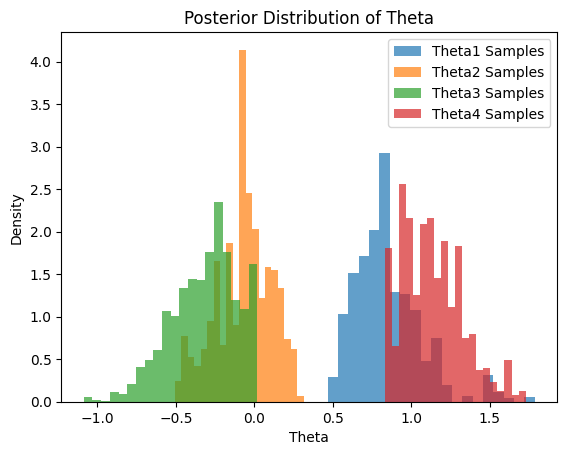

Mean of theta1: 0.8506456017494202
Mean of theta2: -0.06790240854024887
Mean of theta3: -0.32110336422920227
Mean of theta4: 1.1341630220413208
[[0.6856707071570237, 0.07479219888600463], [-0.05770537881008486, 0.8706924686393791]]


In [106]:
X = torch.stack(positions)
# Observations (y): binary data from a Bernoulli distribution
y = torch.stack(observations)

# Define prior parameters
mu = torch.tensor([torch.mean(torch.tensor(pomdp_env.stretch_range)),
                torch.mean(torch.tensor(pomdp_env.shear_range)),
                torch.mean(torch.tensor(pomdp_env.shear_range)),
                torch.mean(torch.tensor(pomdp_env.stretch_range))])
sigma = torch.eye(4) * 0.2  # Identity covariance matrix

# Run Metropolis-Hastings
samples = metropolis_hastings(X,y, num_samples=50000, burn_in=50000, mu=mu, sigma=sigma, proposal_std=0.2)

# Analyze and visualize results
import matplotlib.pyplot as plt

# plot histograms of the samples for each of the four parameter corresponding to samples[:,0], samples[:,1], samples[:,2], samples[:,3]
plt.hist(samples[:,0].numpy(), bins=20, density=True, alpha=0.7, label='Theta1 Samples')
plt.hist(samples[:,1].numpy(), bins=20, density=True, alpha=0.7, label='Theta2 Samples')
plt.hist(samples[:,2].numpy(), bins=20, density=True, alpha=0.7, label='Theta3 Samples')
plt.hist(samples[:,3].numpy(), bins=20, density=True, alpha=0.7, label='Theta4 Samples')
plt.title("Posterior Distribution of Theta")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

print("Mean of theta1:", samples[:,0].mean().item())
print("Mean of theta2:", samples[:,1].mean().item())
print("Mean of theta3:", samples[:,2].mean().item())
print("Mean of theta4:", samples[:,3].mean().item())

print(pomdp_env.transformation_matrix)

# Mean of theta1: 0.8506456017494202
# Mean of theta2: -0.06790240854024887
# Mean of theta3: -0.32110336422920227
# Mean of theta4: 1.1341630220413208
# [[0.6856707071570237, 0.07479219888600463], [-0.05770537881008486, 0.8706924686393791]]